14
1
17


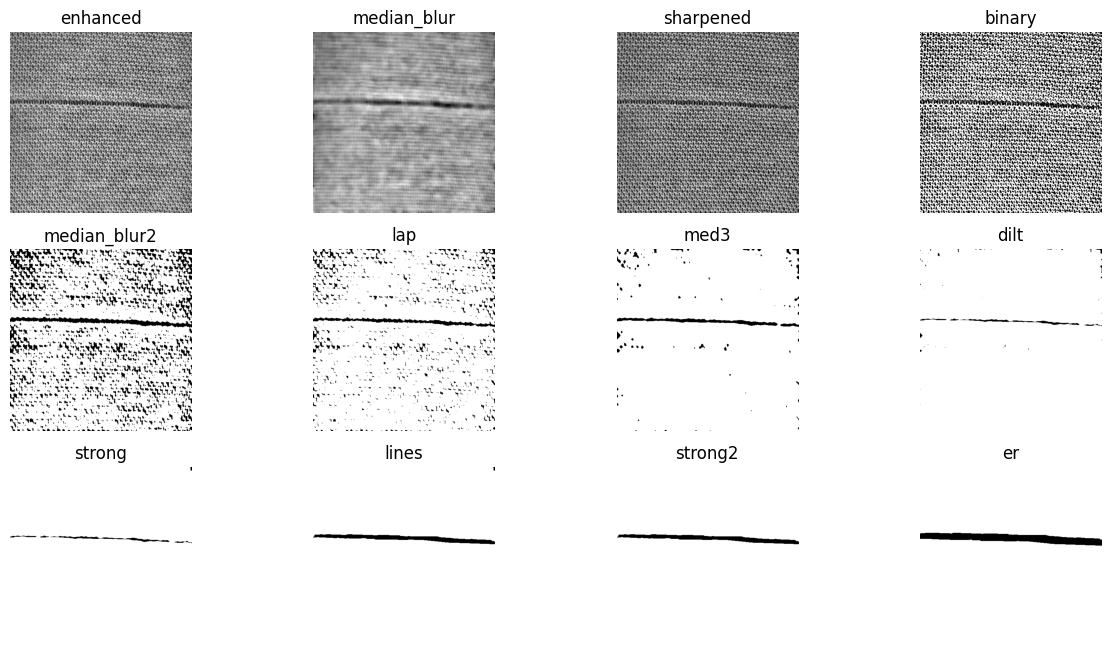

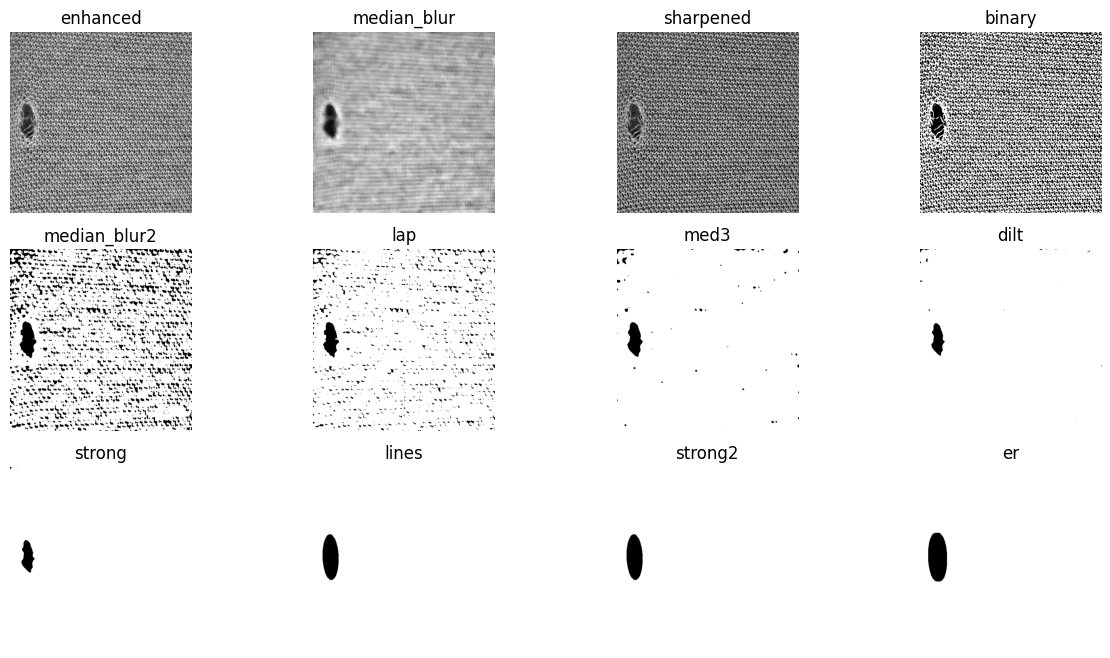

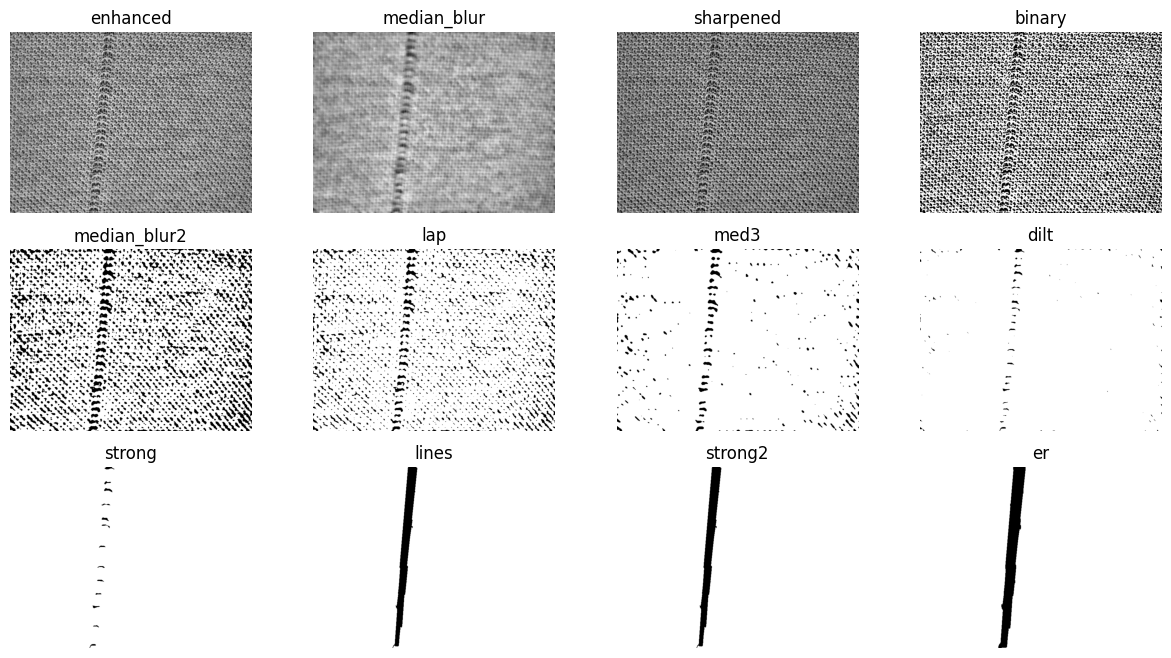

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

num_list = [1, 2, 3]
for num in num_list:
    image = cv2.imread(f'picture/Image{num}.png',-1)
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #提高圖片亮度
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(15, 15))
    enhanced = clahe.apply(gray)
    #中值濾波
    median_blur = cv2.medianBlur(enhanced, 15)
    #影像銳化
    sharpened = cv2.addWeighted(median_blur, -0.3, enhanced, 1, 0)
    
    #二值化
    _, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    #中值濾波
    median_blur2 = cv2.medianBlur(binary, 9)
    
    #拉普拉斯+銳化
    lap = cv2.Laplacian(median_blur2, cv2.CV_64F, ksize=3)
    lap = cv2.convertScaleAbs(lap)
    lap_img = cv2.addWeighted(median_blur2, 1, lap, 1, 0)
        
    median_blur3 = cv2.medianBlur(lap_img, 9)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(median_blur3, kernel, iterations = 1)
    ##影像 強制去躁(Area)
    inverse_img = cv2.bitwise_not(dilation)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inverse_img, connectivity=8)
    strong_sharp = np.ones_like(inverse_img) * 255
    
    sharp_min_area = 60
    
    for i in range(1, num_labels):  # 從 1 開始，因為 0 是背景
        area = stats[i, cv2.CC_STAT_AREA]
        
        if area >= sharp_min_area:
            strong_sharp[labels == i] = 0
            
    canny = cv2.Canny(strong_sharp, 100, 200)
    img_lines = strong_sharp.copy()
    lines = cv2.HoughLinesP(canny, 2, np.pi/180, threshold=30, minLineLength=60, maxLineGap=100)
    print(len(lines))
    for line in lines:   
        if len(lines) < 5:
            contours, _ = cv2.findContours(255 - strong_sharp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            circle_img = np.ones_like(strong_sharp)*255
            ellipse_count = 0
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area < 200:  # 面積範圍調整（太小或太大忽略）
                    continue
                if len(cnt) < 5:  # 至少5個點才能擬合橢圓
                    continue
                
                # 擬合橢圓
                ellipse = cv2.fitEllipse(cnt)  # 返回 (center, axes, angle)
                (xc, yc), (major_axis, minor_axis), angle = ellipse
                
                major = max(major_axis, minor_axis)
                minor = min(major_axis, minor_axis) 
                
                if major == 0:
                    continue
                    
                eccentricity = np.sqrt(1 - (minor / major)**2)
                
                # 篩選條件：偏心率 < 0.95（不太細長），圓形度較高
                perimeter = cv2.arcLength(cnt, True)
                circularity = 4 * np.pi * area / (perimeter**2) if perimeter > 0 else 0
                scale = 1.4
                ellipse = ((xc, yc), (major_axis*scale, minor_axis*scale), angle)
                if eccentricity < 0.95 and circularity > 0.4:
                    cv2.ellipse(circle_img, ellipse ,(0, 0, 0), -1)
                    ellipse_count += 1
                else:
                    break
            if ellipse_count != 0:
                img_lines = circle_img.copy()
        x1, y1, x2, y2 = line[0]
        cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 0), 5)

    ##影像 強制去躁(Area)
    inverse_img2 = cv2.bitwise_not(img_lines)
    num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(inverse_img2, connectivity=8)
    strong_sharp2 = np.ones_like(inverse_img2) * 255
    
    sharp_min_area2 = 100
    
    for i in range(1, num_labels2):  # 從 1 開始，因為 0 是背景
        area2 = stats2[i, cv2.CC_STAT_AREA]
        
        if area2 >= sharp_min_area2:
            strong_sharp2[labels2 == i] = 0
    er = cv2.erode(strong_sharp2, kernel, iterations = 2)
    cv2.imwrite(f'picture/image{num}_detected_result.png', er)
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(3, 4, 1)
    plt.imshow(enhanced, cmap='gray')
    plt.title('enhanced')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(median_blur, cmap='gray')
    plt.title('median_blur')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(sharpened, cmap='gray')
    plt.title('sharpened')
    plt.axis('off')
    
    plt.subplot(3, 4, 4)
    plt.imshow(binary, cmap='gray')
    plt.title('binary')
    plt.axis('off')
    
    plt.subplot(3, 4, 5)
    plt.imshow(median_blur2, cmap='gray')
    plt.title('median_blur2')
    plt.axis('off')
    
    plt.subplot(3, 4, 6)
    plt.imshow(lap_img, cmap='gray')
    plt.title('lap')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(median_blur3, cmap='gray')
    plt.title('med3')
    plt.axis('off')
    
    plt.subplot(3, 4, 8)
    plt.imshow(dilation, cmap='gray')
    plt.title('dilt')
    plt.axis('off')
    
    plt.subplot(3, 4, 9)
    plt.imshow(strong_sharp, cmap='gray')
    plt.title('strong')
    plt.axis('off')
    
    plt.subplot(3, 4, 10)
    plt.imshow(img_lines, cmap='gray')
    plt.title('lines')
    plt.axis('off')
    
    plt.subplot(3, 4, 11)
    plt.imshow(strong_sharp2, cmap='gray')
    plt.title('strong2')
    plt.axis('off')
    
    plt.subplot(3, 4, 12)
    plt.imshow(er, cmap='gray')
    plt.title('er')
    plt.axis('off')


In [39]:
import cv2
import numpy as np
import os
num_list = [1, 2, 3]
for num in num_list:
    img_detect = cv2.imread(f'picture/image{num}_detected_result.png')
    img_ans = cv2.imread(f'picture/image{num}_groundtruth.png')
    
    if img_detect is None or img_ans is None:
        print('error')
    TP = np.sum(np.logical_and(img_detect == 0, img_ans == 0))
    
    # FP: pred == 255 且 gt == 0
    FP = np.sum(np.logical_and(img_detect == 0, img_ans == 255))
    
    # FN: pred == 0 且 gt == 255
    FN = np.sum(np.logical_and(img_detect == 255, img_ans == 0))
    
    TN = np.sum(np.logical_and(img_detect == 255, img_ans == 255))
    
    # 3. 計算指標
    # Accuracy: (所有對的) / (總數)
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
    # Precision: (真的瑕疵) / (所有偵測出的瑕疵)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: (偵測出的瑕疵) / (所有真正的瑕疵)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # 4. 輸出結果 (格式化至小數點後三位)
    print(f"--- 影像 {num} 效能評估結果 ---")
    print(f"Accuracy  (準確度): {accuracy:.3f}")
    print(f"Precision (精確度): {precision:.3f}")
    print(f"Recall    (召回率): {recall:.3f}")
    print("\n")

--- 影像 1 效能評估結果 ---
Accuracy  (準確度): 0.993
Precision (精確度): 0.886
Recall    (召回率): 0.931


--- 影像 2 效能評估結果 ---
Accuracy  (準確度): 0.996
Precision (精確度): 0.915
Recall    (召回率): 0.902


--- 影像 3 效能評估結果 ---
Accuracy  (準確度): 0.973
Precision (精確度): 1.000
Recall    (召回率): 0.612




In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def defect_detection_logic(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #提高圖片亮度
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(15, 15))
    enhanced = clahe.apply(gray)
    #中值濾波
    median_blur = cv2.medianBlur(enhanced, 15)
    #影像銳化
    sharpened = cv2.addWeighted(median_blur, -0.3, enhanced, 1, 0)
    
    #二值化
    _, binary = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    #中值濾波
    median_blur2 = cv2.medianBlur(binary, 9)
    
    #拉普拉斯+銳化
    lap = cv2.Laplacian(median_blur2, cv2.CV_64F, ksize=3)
    lap = cv2.convertScaleAbs(lap)
    lap_img = cv2.addWeighted(median_blur2, 1, lap, 1, 0)
        
    median_blur3 = cv2.medianBlur(lap_img, 9)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(median_blur3, kernel, iterations = 1)
    ##影像 強制去躁(Area)
    inverse_img = cv2.bitwise_not(dilation)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inverse_img, connectivity=8)
    strong_sharp = np.ones_like(inverse_img) * 255
    
    sharp_min_area = 60
    
    for i in range(1, num_labels):  # 從 1 開始，因為 0 是背景
        area = stats[i, cv2.CC_STAT_AREA]
        
        if area >= sharp_min_area:
            strong_sharp[labels == i] = 0
    canny = cv2.Canny(strong_sharp, 100, 200)
    img_lines = strong_sharp.copy()
    lines = cv2.HoughLinesP(canny, 2, np.pi/180, threshold=30, minLineLength=60, maxLineGap=100)
    for line in lines:
        if len(lines) < 5:
            contours, _ = cv2.findContours(255 - strong_sharp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            circle_img = np.ones_like(strong_sharp)*255
            ellipse_count = 0
            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area < 200:  # 面積範圍調整（太小或太大忽略）
                    continue
                if len(cnt) < 5:  # 至少5個點才能擬合橢圓
                    continue
                
                # 擬合橢圓
                ellipse = cv2.fitEllipse(cnt)  # 返回 (center, axes, angle)
                (xc, yc), (major_axis, minor_axis), angle = ellipse
                
                major = max(major_axis, minor_axis)
                minor = min(major_axis, minor_axis) 
                
                if major == 0:
                    continue
                    
                eccentricity = np.sqrt(1 - (minor / major)**2)
                
                # 篩選條件：偏心率 < 0.95（不太細長），圓形度較高
                perimeter = cv2.arcLength(cnt, True)
                circularity = 4 * np.pi * area / (perimeter**2) if perimeter > 0 else 0
                scale = 1.4
                ellipse = ((xc, yc), (major_axis*scale, minor_axis*scale), angle)
                if eccentricity < 0.8 and circularity > 0.4:
                    cv2.ellipse(circle_img, ellipse ,(0, 0, 0), -1)
                    ellipse_count += 1
            if ellipse_count != 0:
                img_lines = circle_img.copy()
        x1, y1, x2, y2 = line[0]
        cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 0), 5)

    ##影像 強制去躁(Area)
    inverse_img2 = cv2.bitwise_not(img_lines)
    num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(inverse_img2, connectivity=8)
    strong_sharp2 = np.ones_like(inverse_img2) * 255
    
    sharp_min_area2 = 100
    
    for i in range(1, num_labels2):  # 從 1 開始，因為 0 是背景
        area2 = stats2[i, cv2.CC_STAT_AREA]
        
        if area2 >= sharp_min_area2:
            strong_sharp2[labels2 == i] = 0
    er = cv2.erode(strong_sharp2, kernel, iterations = 2)
    return er
    
# --- 2. 處理影片輸出 ---
video_path = 'picture/texture_video_30s.mp4'

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("錯誤：無法開啟影片，請確認路徑是否正確，或檔案是否損壞")
    exit()

print("影片開啟成功！開始偵測，按 'q' 鍵隨時結束")

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("影片播放完畢")
        break
    
    frame_count += 1
    
    mask = defect_detection_logic(frame)
    scale = 0.5
    width = int(mask.shape[1] * scale)
    height = int(mask.shape[0] * scale)
    
    # 使用 INTER_AREA 在縮小時效果較好
    resized_img = cv2.resize(mask, (width, height), interpolation=cv2.INTER_AREA)
    # cv2.imshow("frame", frame)
    cv2.imshow("mask", resized_img)
    
    # 按 q 結束
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("使用者中斷")
        break

cap.release()
cv2.destroyAllWindows()
print(f"處理完成！總共處理了 {frame_count} 幀")

影片開啟成功！開始偵測，按 'q' 鍵隨時結束
影片播放完畢
處理完成！總共處理了 901 幀
